# Download library

In [1]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.8 MB/s eta 0:00:00


In [2]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 4.7 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-lgi68xxq
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-lgi68xxq
  Resolved https://github.com/huggingface/accelerate to commit 420743af22c34a72b19970a97ae829e31285c49e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.24.0.dev0-py3-none-any.whl size=258253 sha256=ab7004a411c3cb08a37465754c79323bdb99315b97d60295cb6867aa5041f243
  Stored in directory: /tmp/pip-ephem-wheel-cache-pu4l__jd/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.23.0
    Uninstalling accelerate-0.23.0:
      Successfully uninstalled accelerate-0.23.0


# Load data and pre-processing

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [6]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [7]:
train_p = pd.read_csv("/content/drive/MyDrive/data/train_p.csv")
test_p = pd.read_csv('/content/drive/MyDrive/data/test_p.csv')

train_r = pd.read_csv("/content/drive/MyDrive/data/train_r.csv")
test_r = pd.read_csv('/content/drive/MyDrive/data/test_r.csv')

In [8]:
valid_p = pd.read_csv("/content/drive/MyDrive/data/valid_p.csv")
valid_r = pd.read_csv('/content/drive/MyDrive/data/valid_r.csv')

In [9]:
P_labels=['information','design action', 'failure action','failure reasoning', 'perception']
R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

#Config

In [10]:
# params
bert_lr = 2e-5
max_length=256
epoch = 20
patience = 2
factor = 0.5
# loss function
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss().to(device)
#batch size
batch_size = 16
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
n_train_r=len(train_r)
n_valid_r=len(valid_r)

n_train_p=len(train_p)
n_valid_p=len(valid_p)


# Model

In [11]:
class TextDataset(Dataset):

    def __init__(self, text, targets, tokenizer):

        self.targets = targets
        self.text = list(text)
        self.tokenizer = tokenizer
        self.encoded_captions = tokenizer(self.text, padding=True, truncation=True, max_length=max_length)

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        item = {
            key: torch.tensor(values[index])
            for key, values in self.encoded_captions.items()
        }

        item['target'] = self.targets[index]

        return item


def create_text_loader(df, shuffle=True):
    ds = TextDataset(text=df['text'].values,
                     targets=df['index'].values,
                     tokenizer=tokenizer)

    return DataLoader(ds,
                      batch_size=batch_size
                      ,shuffle=shuffle)



In [12]:
class Bert(nn.Module):

  def __init__(self, n_classes):
    super(Bert, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.out(pooled_output)
    return output

In [13]:
import torch
torch.cuda.empty_cache()

In [14]:
def train_epoch(model, train_dataloader, optimizer, scheduler, n_train):
    model = model.train()
    losses = []
    correct_predictions = 0
    process_bar = tqdm(train_dataloader)
    for d in process_bar:
        d = {k: v.to(device) for k, v in d.items() if k != "text"}
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d['target'].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()
        process_bar.set_postfix(train_loss=loss.item())

    return correct_predictions.double() / n_train, np.mean(losses)

def eval_model(model, val_dataloader, n_valid):
    model = model.eval()

    losses = []
    correct_predictions = 0
    process_bar = tqdm(val_dataloader)
    for d in process_bar:
        d = {k: v.to(device) for k, v in d.items() if k != "text"}
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["target"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        process_bar.set_postfix(val_loss=loss.item())

    return correct_predictions.double() / n_valid, np.mean(losses)


def get_predictions(model, test_data_loader):
    model = model.eval()
    predictions = []
    real_values = []

    for d in test_data_loader:
        d = {k: v.to(device) for k, v in d.items() if k != "text"}
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["target"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)

        probs = F.softmax(outputs, dim=1)

        predictions.extend(preds)
        real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, real_values

In [15]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted')

# Researcher

In [16]:
train_dataloader = create_text_loader(train_r, shuffle=True)
val_dataloader = create_text_loader(valid_r, shuffle=False)
test_dataloader = create_text_loader(test_r, shuffle=False)

In [17]:
model=Bert(5).to(device)
optimizer = AdamW(model.parameters(), lr=bert_lr,correct_bias=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=patience, factor=factor)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [18]:
for e in range(epoch):

  print(f'Epoch {e + 1}/{epoch}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,
                                      train_dataloader,
                                      optimizer,
                                      scheduler,
                                      n_train_r)
  print(f'Train loss {train_loss} accuracy {train_acc}')
  with torch.no_grad():
      val_acc, val_loss = eval_model(model, val_dataloader, n_valid_r)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()
  scheduler.step(val_loss)

torch.save(model, '/content/drive/MyDrive/Model/R_text_model.pt')

Epoch 1/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 1.1655169435237582 accuracy 0.5676567656765676


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.1106304089228312 accuracy 0.5833333333333333

Epoch 2/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.8065849466804873 accuracy 0.7051705170517051


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 0.9998244603474935 accuracy 0.631578947368421

Epoch 3/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.44151943144306804 accuracy 0.8547854785478547


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.1703630805015564 accuracy 0.6271929824561403

Epoch 4/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.17600782070178211 accuracy 0.9438943894389439


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.5616705775260926 accuracy 0.6184210526315789

Epoch 5/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.07645382496360853 accuracy 0.9779977997799779


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.8979600228369236 accuracy 0.5964912280701754

Epoch 6/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.022254132296024055 accuracy 0.9955995599559956


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.053849800427755 accuracy 0.6359649122807017

Epoch 7/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.008770606906884432 accuracy 0.9983498349834983


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.124000382423401 accuracy 0.6403508771929824

Epoch 8/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.007614957962926526 accuracy 0.9983498349834983


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.26803507010142 accuracy 0.6228070175438596

Epoch 9/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.006445853607147001 accuracy 0.9983498349834983


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.2553894917170205 accuracy 0.6271929824561403

Epoch 10/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.005612429788718082 accuracy 0.9988998899889988


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.2860630909601847 accuracy 0.6447368421052632

Epoch 11/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.003668347493849548 accuracy 0.9988998899889988


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.3439043124516803 accuracy 0.6359649122807017

Epoch 12/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.004199881264133167 accuracy 0.9988998899889988


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.3426455656687417 accuracy 0.6403508771929824

Epoch 13/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.003540252867663328 accuracy 0.9988998899889988


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.3489202499389648 accuracy 0.631578947368421

Epoch 14/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.0028702094099124927 accuracy 0.9988998899889988


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.367629067103068 accuracy 0.631578947368421

Epoch 15/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.00316666099247972 accuracy 0.9988998899889988


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.376202853520711 accuracy 0.631578947368421

Epoch 16/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.0029175274465702834 accuracy 0.9988998899889988


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.383859650293986 accuracy 0.6271929824561403

Epoch 17/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.0032344083066849984 accuracy 0.9988998899889988


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.385880621274312 accuracy 0.6271929824561403

Epoch 18/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.0035586275102615587 accuracy 0.9983498349834983


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.3916418234507244 accuracy 0.6271929824561403

Epoch 19/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.002586249634572468 accuracy 0.9988998899889988


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.397654430071513 accuracy 0.6271929824561403

Epoch 20/20
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.00274706949130632 accuracy 0.9988998899889988


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.3961308797200522 accuracy 0.631578947368421



In [19]:
with torch.no_grad():
  y_pred, y_test=get_predictions(model, test_dataloader)

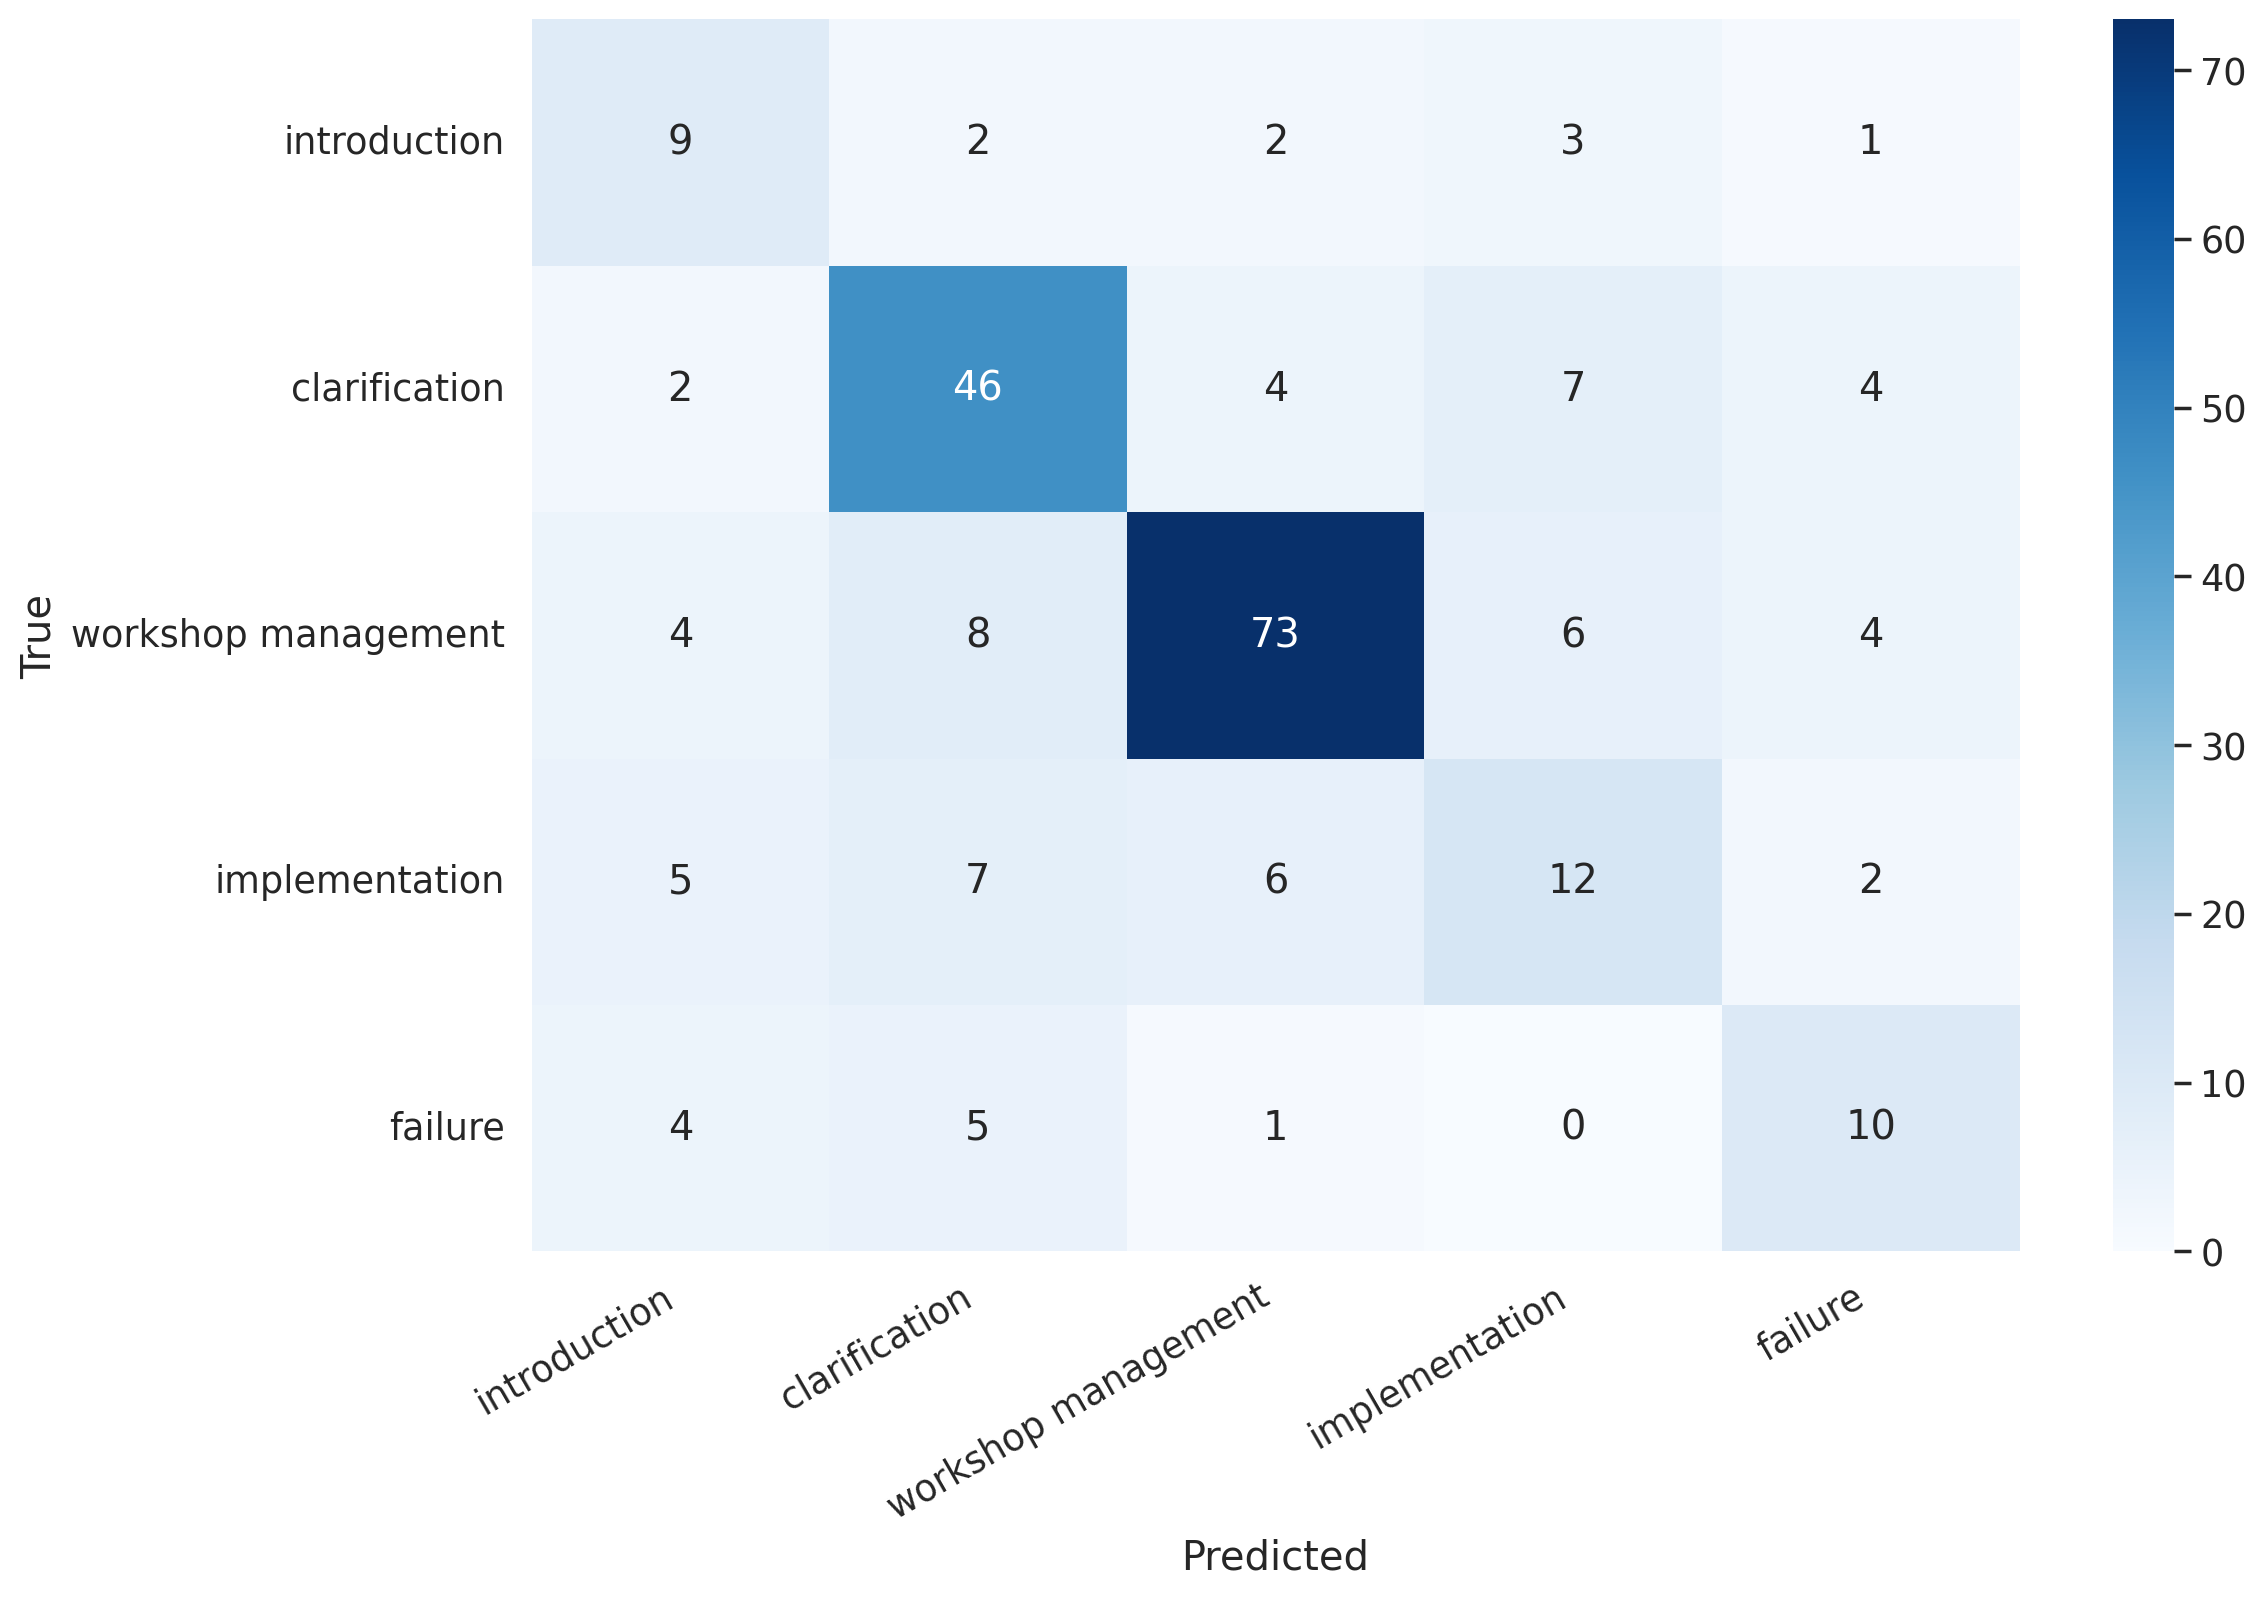

In [20]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=R_labels, columns=R_labels)
show_confusion_matrix(df_cm)

In [21]:
print(classification_report(y_test, y_pred, target_names=R_labels))

                     precision    recall  f1-score   support

       introduction       0.38      0.53      0.44        17
      clarification       0.68      0.73      0.70        63
workshop management       0.85      0.77      0.81        95
     implementation       0.43      0.38      0.40        32
            failure       0.48      0.50      0.49        20

           accuracy                           0.66       227
          macro avg       0.56      0.58      0.57       227
       weighted avg       0.67      0.66      0.66       227



# Participant

In [22]:
train_dataloader_p = create_text_loader(train_p, shuffle=True)
val_dataloader_p = create_text_loader(valid_p, shuffle=False)
test_dataloader_p = create_text_loader(test_p, shuffle=False)

In [23]:
model=Bert(5).to(device)
optimizer = AdamW(model.parameters(), lr=bert_lr,correct_bias=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=patience, factor=factor)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [24]:
for e in range(epoch):

  print(f'Epoch {e + 1}/{epoch}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,
                                      train_dataloader_p,
                                      optimizer,
                                      scheduler,
                                      n_train_p)
  print(f'Train loss {train_loss} accuracy {train_acc}')
  with torch.no_grad():
      val_acc, val_loss = eval_model(model, val_dataloader_p, n_valid_p)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()
  scheduler.step(val_loss)

torch.save(model, '/content/drive/MyDrive/Model/P_text_model.pt')

Epoch 1/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 1.4534318774611086 accuracy 0.34644582470669427


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.4448389907677968 accuracy 0.39560439560439564

Epoch 2/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 1.178640799862998 accuracy 0.538992408557626


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.3553691705067952 accuracy 0.5

Epoch 3/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.7585924634566674 accuracy 0.7336093857832988


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.5257213910420735 accuracy 0.5054945054945056

Epoch 4/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.3887399938571584 accuracy 0.8757763975155279


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.9437890648841858 accuracy 0.4835164835164836

Epoch 5/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.19081408660449498 accuracy 0.9406487232574189


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.4408983290195465 accuracy 0.48901098901098905

Epoch 6/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.06804589387848155 accuracy 0.9799861973775017


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.7694684068361917 accuracy 0.4835164835164836

Epoch 7/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.022154254461433945 accuracy 0.9937888198757764


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.9284965892632804 accuracy 0.47252747252747257

Epoch 8/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.01646361101270336 accuracy 0.9951690821256038


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.1976682345072427 accuracy 0.4835164835164836

Epoch 9/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.005666086870465673 accuracy 0.9993098688750863


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.249151666959127 accuracy 0.4835164835164836

Epoch 10/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.00754281193731803 accuracy 0.9986197377501725


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.1871397495269775 accuracy 0.48901098901098905

Epoch 11/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.0032722197574113015 accuracy 0.9986197377501725


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.328181038300196 accuracy 0.48901098901098905

Epoch 12/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.0022747040084041244 accuracy 0.9993098688750863


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.328754256169001 accuracy 0.4835164835164836

Epoch 13/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.003908155851864389 accuracy 0.9986197377501725


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.349455495675405 accuracy 0.4835164835164836

Epoch 14/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.0018821074141209925 accuracy 0.9993098688750863


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.374879240989685 accuracy 0.48901098901098905

Epoch 15/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.002327513624530204 accuracy 0.9993098688750863


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.392699380715688 accuracy 0.4835164835164836

Epoch 16/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.0031649384425011472 accuracy 0.9986197377501725


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.413205087184906 accuracy 0.4835164835164836

Epoch 17/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.0021273743368910403 accuracy 0.9986197377501725


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.4180214007695517 accuracy 0.4835164835164836

Epoch 18/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.002656423413849712 accuracy 0.9993098688750863


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.4230124155680337 accuracy 0.4835164835164836

Epoch 19/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.0021118493907404346 accuracy 0.9993098688750863


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.4206448992093406 accuracy 0.4835164835164836

Epoch 20/20
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.0016377066443725439 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.4267901182174683 accuracy 0.4835164835164836



In [25]:
with torch.no_grad():
  y_pred, y_test=get_predictions(model, test_dataloader_p)

In [26]:
acc=balanced_accuracy_score(y_test, y_pred)
acc

0.48672633672633675

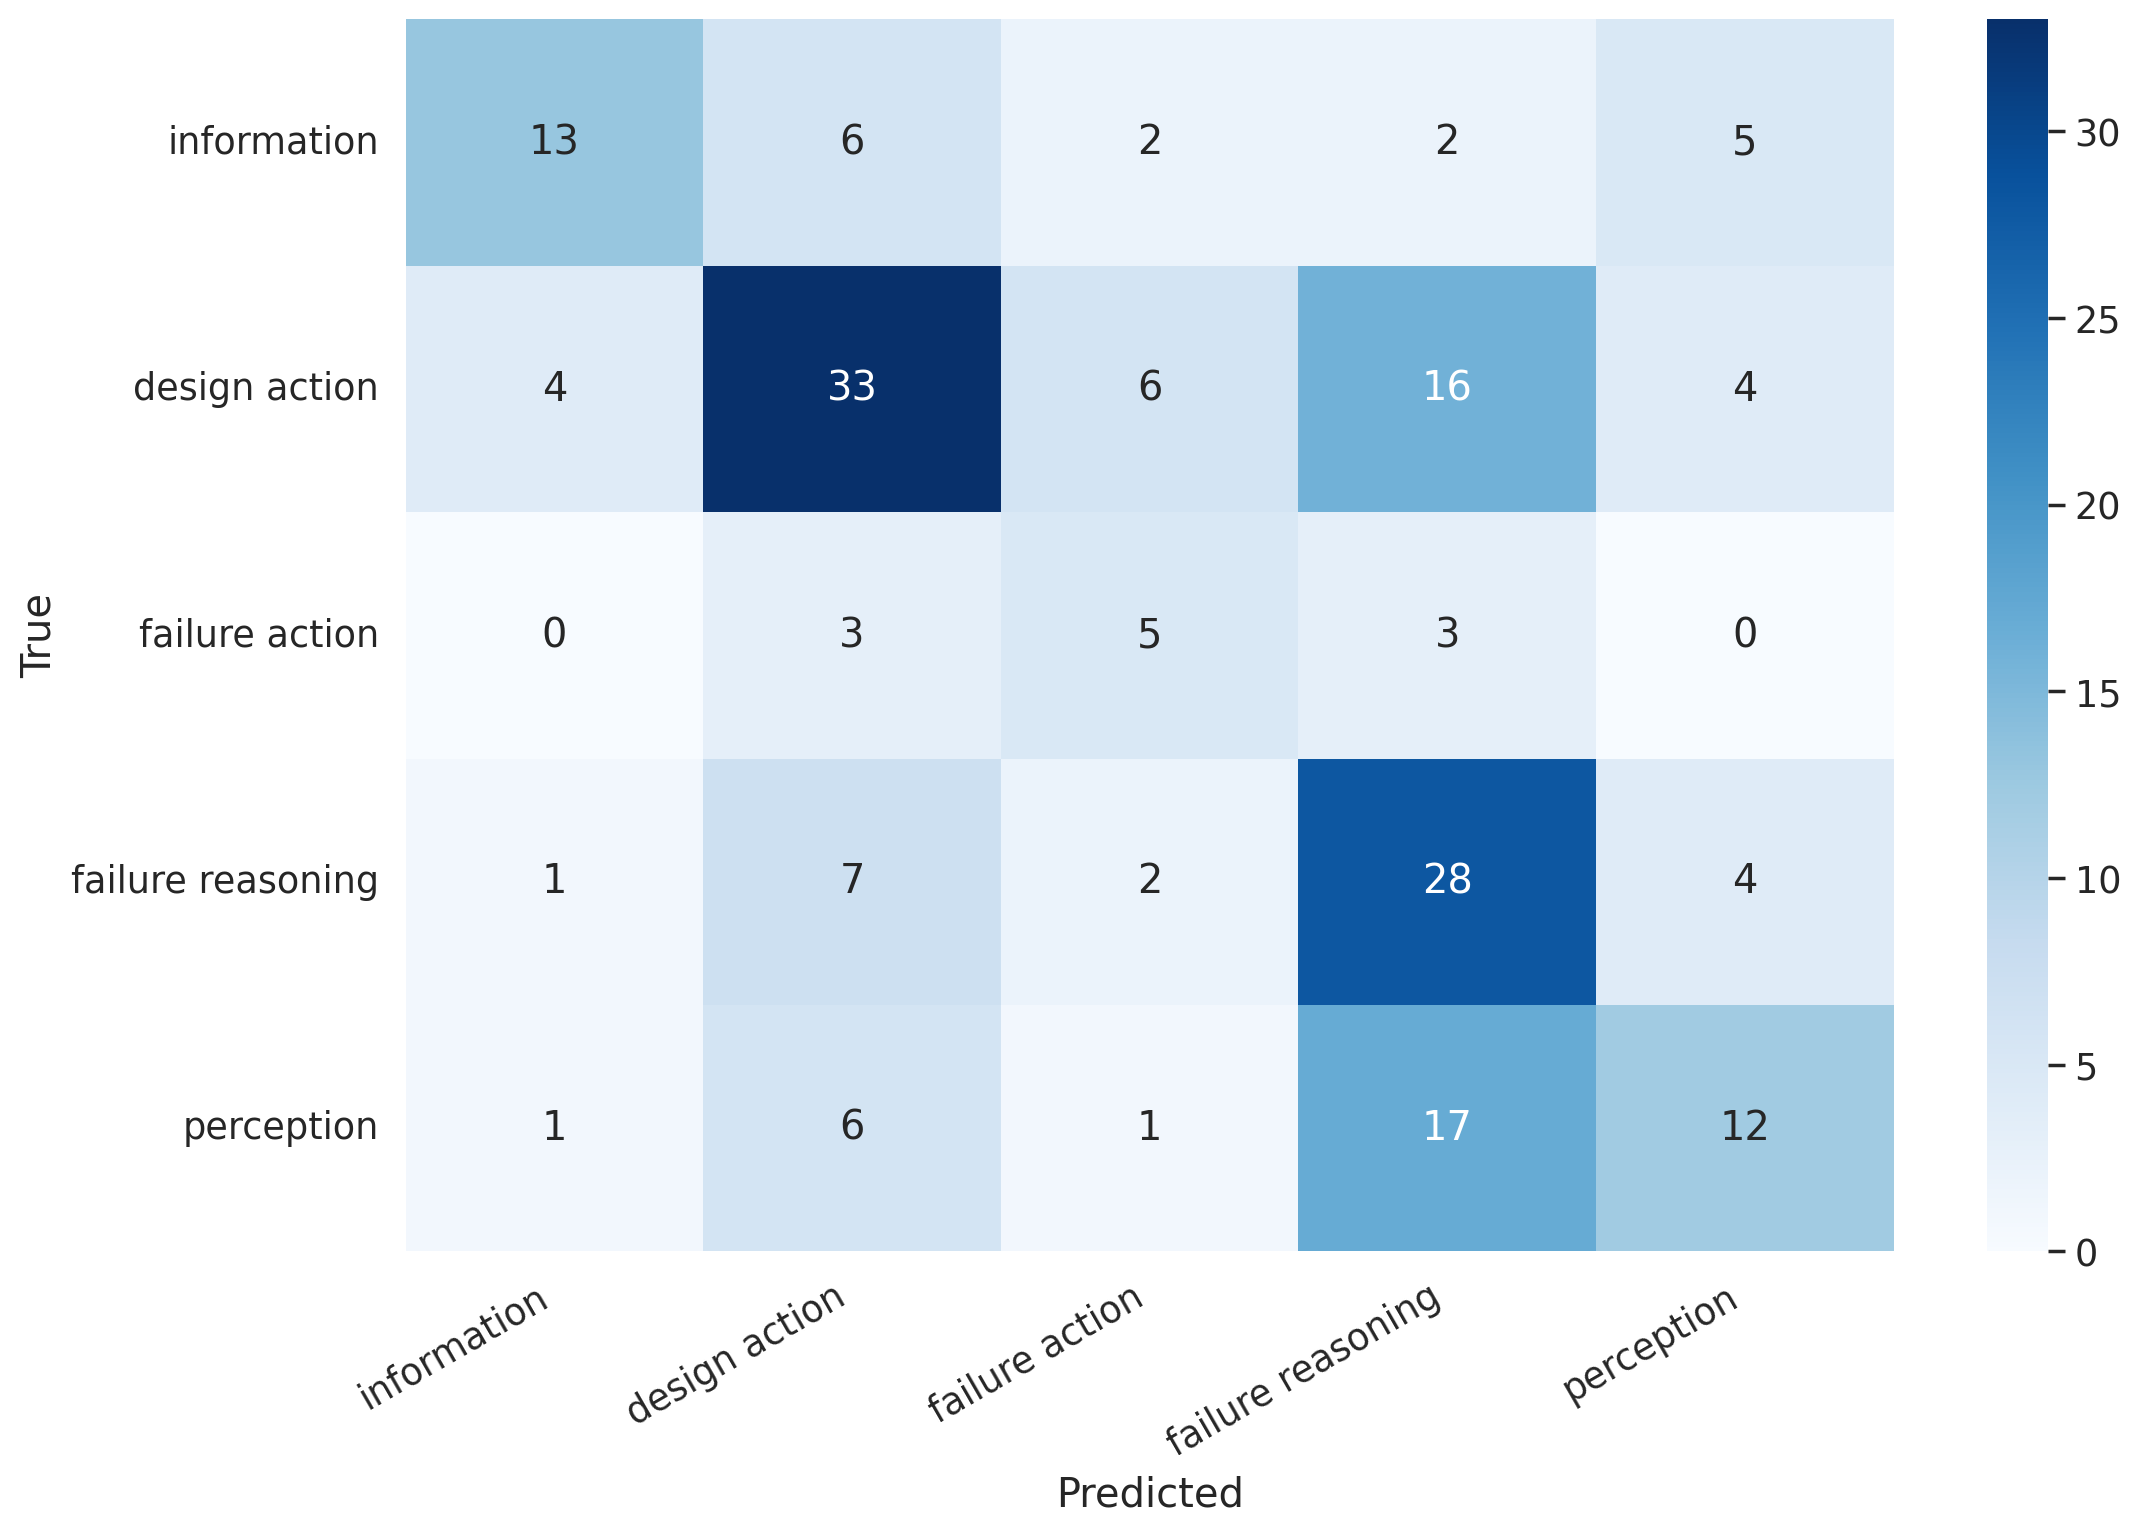

In [27]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=P_labels, columns=P_labels)
show_confusion_matrix(df_cm)

In [28]:
print(classification_report(y_test, y_pred, target_names=P_labels))

                   precision    recall  f1-score   support

      information       0.68      0.46      0.55        28
    design action       0.60      0.52      0.56        63
   failure action       0.31      0.45      0.37        11
failure reasoning       0.42      0.67      0.52        42
       perception       0.48      0.32      0.39        37

         accuracy                           0.50       181
        macro avg       0.50      0.49      0.48       181
     weighted avg       0.53      0.50      0.50       181

